In [21]:
! pip install -U --quiet llama-cpp-python tavily-python langgraph

### Repo

Clone and build Llama.cpp, following instructions here:

https://github.com/ggerganov/llama.cpp

### Model

Download a local LLM, ideally one that is capable of tool calling to use all features discussed below:

> Hermes 2 Pro is an upgraded version of Nous Hermes 2, consisting of an updated and cleaned version of the OpenHermes 2.5 Dataset, as well as a newly introduced Function Calling and JSON Mode dataset developed in-house. This new version of Hermes maintains its excellent general task and conversation capabilities - but also excels at Function Calling
 
* Weights: `Hermes-2-Pro-Llama-3-8B-Q8_0.gguf`
* Link: https://huggingface.co/NousResearch/Hermes-2-Pro-Llama-3-8B-GGUF

In [1]:
local_model = "/Users/rlm/Desktop/Code/llama.cpp/models/Hermes-2-Pro-Llama-3-8B-Q8_0.gguf"

In [2]:
from langchain_community.chat_models import ChatLlamaCpp

In [ ]:
import multiprocessing

from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = ChatLlamaCpp(
    temperature=0.3,
    model_path=local_model,
    n_ctx=10000,
    n_gpu_layers=4,
    n_batch=200,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    max_tokens=512,
    n_threads=multiprocessing.cpu_count() - 1,
    callback_manager=CallbackManager(
        [StreamingStdOutCallbackHandler()]
    ),  # Callbacks support token-wise streaming
    streaming=True,
    repeat_penalty=1.5,
    top_p=0.5,
    stop=["<|end_of_text|>", "<|eot_id|>"],
    verbose=True,
)

### Invoke

In [4]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]

ai_msg = llm.invoke(messages)
ai_msg

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?


J'aime programmer (in France) or J'adore programmeur(programmer in Quebec). Both translations convey an enthusiastic feeling for loving computer programing, but note there is no direct translation of "programming" to French as it's a specific field and the word doesn't exist by itself.


llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =      16.53 ms /    61 runs   (    0.27 ms per token,  3690.26 tokens per second)
llama_print_timings: prompt eval time =   14486.29 ms /    35 tokens (  413.89 ms per token,     2.42 tokens per second)
llama_print_timings:        eval time =    6595.61 ms /    60 runs   (  109.93 ms per token,     9.10 tokens per second)
llama_print_timings:       total time =   21156.22 ms /    95 tokens


AIMessage(content='J\'aime programmer (in France) or J\'adore programmeur(programmer in Quebec). Both translations convey an enthusiastic feeling for loving computer programing, but note there is no direct translation of "programming" to French as it\'s a specific field and the word doesn\'t exist by itself.', response_metadata={'finish_reason': 'stop'}, id='run-f8c421fc-f022-4e47-ab1e-3b7fe80be36e-0')

### Chain

In [5]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm
chain.invoke(
    {
        "input_language": "English",
        "output_language": "German",
        "input": "I love programming.",
    }
)

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit


Ich liebe Programmieren.

Translation: I (ich) + Love/like (liebe)+ Verb -ing form (-nd, -en or –t as suffix of verb infinitive in german language )+ noun “programming”(Programmierung). So the translation is "I love programming" which translates to  Ich Liebe programmierun.


llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =      19.22 ms /    71 runs   (    0.27 ms per token,  3694.45 tokens per second)
llama_print_timings: prompt eval time =     721.99 ms /    16 tokens (   45.12 ms per token,    22.16 tokens per second)
llama_print_timings:        eval time =    8322.44 ms /    70 runs   (  118.89 ms per token,     8.41 tokens per second)
llama_print_timings:       total time =    9128.37 ms /    86 tokens


AIMessage(content='Ich liebe Programmieren.\n\nTranslation: I (ich) + Love/like (liebe)+ Verb -ing form (-nd, -en or –t as suffix of verb infinitive in german language )+ noun “programming”(Programmierung). So the translation is "I love programming" which translates to  Ich Liebe programmierun.', response_metadata={'finish_reason': 'stop'}, id='run-e6cc700a-ac9d-42c5-8ad1-47fe0b4ef4ea-0')

### Structured output

In [7]:
from langchain_core.pydantic_v1 import BaseModel
from langchain_core.utils.function_calling import convert_to_openai_tool

class Joke(BaseModel):
    '''A setup to a joke and the punchline.'''
    setup: str
    punchline: str

dict_schema = convert_to_openai_tool(Joke)
structured_llm = llm.with_structured_output(dict_schema)
result = structured_llm.invoke("Tell me a joke about birds")
result

from_string grammar:
char ::= [^"\] | [\] char_1 
char_1 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
punchline-kv ::= ["] [p] [u] [n] [c] [h] [l] [i] [n] [e] ["] space [:] space string 
space ::= space_7 
string ::= ["] string_8 ["] space 
root ::= [{] space setup-kv [,] space punchline-kv [}] space 
setup-kv ::= ["] [s] [e] [t] [u] [p] ["] space [:] space string 
space_7 ::= [ ] | 
string_8 ::= char string_8 | 

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =     296.98 ms /    32 runs   (    9.28 ms per token,   107.75 tokens per second)
llama_print_timings: prompt eval time =     348.76 ms /     6 tokens (   58.13 ms per token,    17.20 tokens per second)
llama_print_t

{'setup': "Why don't seagulls fly over the sea?",
 'punchline': "Because they'd get waterlogged!"}

### Tool calling

* However, it cannot automatically trigger a function/tool. 
* We need to force it by specifying the 'tool choice' parameter. This parameter is typically formatted as described below.

In [35]:
from langchain.tools import tool
from langchain_core.pydantic_v1 import BaseModel, Field

class WeatherInput(BaseModel):
    location: str = Field(description="The city and state, e.g. San Francisco, CA")
    unit: str = Field(enum=["celsius", "fahrenheit"])

@tool("get_current_weather", args_schema=WeatherInput)
def get_weather(location: str, unit: str):
    """Get the current weather in a given location"""
    return f"Now the weather in {location} is 22 {unit}"

llm_with_tools = llm.bind_tools(
    tools=[get_weather],
    tool_choice={"type": "function", "function": {"name": "get_current_weather"}},
)

ai_msg = llm_with_tools.invoke(
    "what is the weather like in HCMC in celsius",
)

ai_msg

from_string grammar:
char ::= [^"\] | [\] char_1 
char_1 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
location-kv ::= ["] [l] [o] [c] [a] [t] [i] [o] [n] ["] space [:] space string 
space ::= space_7 
string ::= ["] string_8 ["] space 
root ::= [{] space location-kv [,] space unit-kv [}] space 
unit-kv ::= ["] [u] [n] [i] [t] ["] space [:] space unit 
space_7 ::= [ ] | 
string_8 ::= char string_8 | 
unit ::= ["] [c] [e] [l] [s] [i] [u] [s] ["] | ["] [f] [a] [h] [r] [e] [n] [h] [e] [i] [t] ["] 

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =     148.92 ms /    19 runs   (    7.84 ms per token,   127.58 tokens per second)
llama_print_timings: prompt eval time =     824.90 m

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_weather', 'arguments': '{ "location": "Ho Chi Minh City", "unit":"celsius"} '}, 'tool_calls': [{'id': 'call__0_get_current_weather_cmpl-63f51030-8ecd-43e6-b3fa-5e3e2e29ff35', 'type': 'function', 'function': {'name': 'get_current_weather', 'arguments': '{ "location": "Ho Chi Minh City", "unit":"celsius"} '}}]}, response_metadata={'token_usage': {'prompt_tokens': 22, 'completion_tokens': 18, 'total_tokens': 40}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1abf34ef-8f51-459a-b25b-4204ea18e4a7-0', tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'Ho Chi Minh City', 'unit': 'celsius'}, 'id': 'call__0_get_current_weather_cmpl-63f51030-8ecd-43e6-b3fa-5e3e2e29ff35'}])

In [62]:
class MagicFunctionInput(BaseModel):
    magic_function_input: int = Field(description="The input value for magic function")

@tool("get_magic_function", args_schema=MagicFunctionInput)
def magic_function(magic_function_input: int):
    """Get the value of magic function for an input."""
    return value + 2

llm_with_tools = llm.bind_tools(
    tools=[magic_function],
    tool_choice={"type": "function", "function": {"name": "get_magic_function"}},
)

ai_msg = llm_with_tools.invoke(
    "What is magic function of 3?",
)

ai_msg

from_string grammar:
integer ::= integer_1 space 
integer_1 ::= integer_2 integral-part 
integer_2 ::= [-] | 
integral-part ::= [0-9] | [1-9] integral-part_34 
space ::= space_37 
integral-part_5 ::= [0-9] integral-part_33 
integral-part_6 ::= [0-9] integral-part_32 
integral-part_7 ::= [0-9] integral-part_31 
integral-part_8 ::= [0-9] integral-part_30 
integral-part_9 ::= [0-9] integral-part_29 
integral-part_10 ::= [0-9] integral-part_28 
integral-part_11 ::= [0-9] integral-part_27 
integral-part_12 ::= [0-9] integral-part_26 
integral-part_13 ::= [0-9] integral-part_25 
integral-part_14 ::= [0-9] integral-part_24 
integral-part_15 ::= [0-9] integral-part_23 
integral-part_16 ::= [0-9] integral-part_22 
integral-part_17 ::= [0-9] integral-part_21 
integral-part_18 ::= [0-9] integral-part_20 
integral-part_19 ::= [0-9] 
integral-part_20 ::= integral-part_19 | 
integral-part_21 ::= integral-part_18 | 
integral-part_22 ::= integral-part_17 | 
integral-part_23 ::= integral-part_16 | 
int

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_magic_function', 'arguments': '{"magic_function_input": 3}'}, 'tool_calls': [{'id': 'call__0_get_magic_function_cmpl-d7088e2e-02c4-4505-a051-2cc37878d6a8', 'type': 'function', 'function': {'name': 'get_magic_function', 'arguments': '{"magic_function_input": 3}'}}]}, response_metadata={'token_usage': {'prompt_tokens': 18, 'completion_tokens': 9, 'total_tokens': 27}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89867ecb-1d3b-4242-8f37-3e896c1f1f81-0', tool_calls=[{'name': 'get_magic_function', 'args': {'magic_function_input': 3}, 'id': 'call__0_get_magic_function_cmpl-d7088e2e-02c4-4505-a051-2cc37878d6a8'}])

In [ ]:
import os
from getpass import getpass
TAVILY_API_KEY = getpass()
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [84]:
class WebSearchInput(BaseModel):
    search_query: str = Field(description="Search query to pass to web search")
    
@tool("get_web_search", args_schema=WebSearchInput)
def get_web_search(search_query: str): #
    """Get web search results for a query"""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": search_query})
    return docs

llm_with_tools = llm.bind_tools(
    tools=[get_web_search],
    tool_choice={"type": "function", "function": {"name": "get_web_search"}},
)

ai_msg = llm_with_tools.invoke(
    "what is the weather like in HCMC in celsius",
)

ai_msg

from_string grammar:
char ::= [^"\] | [\] char_1 
char_1 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
root ::= [{] space search-query-kv [}] space 
space ::= space_6 
search-query-kv ::= ["] [s] [e] [a] [r] [c] [h] [_] [q] [u] [e] [r] [y] ["] space [:] space string 
string ::= ["] string_7 ["] space 
space_6 ::= [ ] | 
string_7 ::= char string_7 | 

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =     169.86 ms /    18 runs   (    9.44 ms per token,   105.97 tokens per second)
llama_print_timings: prompt eval time =     800.94 ms /    19 tokens (   42.15 ms per token,    23.72 tokens per second)
llama_print_timings:        eval time =    1740.33 ms /    17 runs   (  102.37 

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_web_search', 'arguments': '{ "search_query": "weather Ho Chi Minh City, Vietnam today Celsius" }'}, 'tool_calls': [{'id': 'call__0_get_web_search_cmpl-8c9d8e91-4f6b-4c6d-b994-24297e21c2c6', 'type': 'function', 'function': {'name': 'get_web_search', 'arguments': '{ "search_query": "weather Ho Chi Minh City, Vietnam today Celsius" }'}}]}, response_metadata={'token_usage': {'prompt_tokens': 22, 'completion_tokens': 17, 'total_tokens': 39}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-455c7255-838b-4042-ac59-227cc04b0606-0', tool_calls=[{'name': 'get_web_search', 'args': {'search_query': 'weather Ho Chi Minh City, Vietnam today Celsius'}, 'id': 'call__0_get_web_search_cmpl-8c9d8e91-4f6b-4c6d-b994-24297e21c2c6'}])

In [61]:
ai_msg = llm_with_tools.invoke(
    "who was the first draft pick in the NFL draft?",
)

ai_msg

from_string grammar:
char ::= [^"\] | [\] char_1 
char_1 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
root ::= [{] space search-query-kv [}] space 
space ::= space_6 
search-query-kv ::= ["] [s] [e] [a] [r] [c] [h] [_] [q] [u] [e] [r] [y] ["] space [:] space string 
string ::= ["] string_7 ["] space 
space_6 ::= [ ] | 
string_7 ::= char string_7 | 

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit

llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =     124.74 ms /    14 runs   (    8.91 ms per token,   112.24 tokens per second)
llama_print_timings: prompt eval time =     798.52 ms /    16 tokens (   49.91 ms per token,    20.04 tokens per second)
llama_print_timings:        eval time =    1307.02 ms /    13 runs   (  100.54 

AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_web_search', 'arguments': '{ "search_query": "first nfl draft pick" } '}, 'tool_calls': [{'id': 'call__0_get_web_search_cmpl-710322d0-3264-4fcc-a2a3-9a0e9ea2c4ed', 'type': 'function', 'function': {'name': 'get_web_search', 'arguments': '{ "search_query": "first nfl draft pick" } '}}]}, response_metadata={'token_usage': {'prompt_tokens': 21, 'completion_tokens': 13, 'total_tokens': 34}, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f2e759b1-eba1-47a5-8e40-96fd2997391b-0', tool_calls=[{'name': 'get_web_search', 'args': {'search_query': 'first nfl draft pick'}, 'id': 'call__0_get_web_search_cmpl-710322d0-3264-4fcc-a2a3-9a0e9ea2c4ed'}])

In [72]:
# Test w/o tool choice specified
llm_with_tools = llm.bind_tools(
    tools=[get_web_search],
)

ai_msg = llm_with_tools.invoke(
    "what is the weather like in HCMC in celsius. use a tool call.",
)

ai_msg

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?
Llama.generate: prefix-match hit


To provide you with accurate and up-to-date information about Ho Chi Minh City's current temperature, I would need to access an online source or API that provides real-time data on global temperatures.

One such service could be OpenWeatherMap (https://openweathermap.org/), which offers a range of APIs for accessing weather-related datasets. 

To get the latest 5-day forecast in Celsius degrees and other details like humidity, wind speed etc., you can use their One Call API by providing your desired location coordinates or city name.

Here's an example Python code snippet using OpenWeatherMap’s one call api:

```python
import requests

# Replace YOUR_API_KEY with a valid access key from https://openweathermap.org/appid 
API_key = 'YOUR_APP_ID'

def get_weather_data(city_name):
    base_url ='http://api.openweathermap.org/data/2.5/weather'
    
   # Get the current weather data for given city
    response= requests.get(base_url, params={'q':city_name,'appid' : API_KEY})
  
  if(response


llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =      87.81 ms /   310 runs   (    0.28 ms per token,  3530.35 tokens per second)
llama_print_timings: prompt eval time =    2011.78 ms /    11 tokens (  182.89 ms per token,     5.47 tokens per second)
llama_print_timings:        eval time =   39709.35 ms /   309 runs   (  128.51 ms per token,     7.78 tokens per second)
llama_print_timings:       total time =   42158.45 ms /   320 tokens


AIMessage(content="To provide you with accurate and up-to-date information about Ho Chi Minh City's current temperature, I would need to access an online source or API that provides real-time data on global temperatures.\n\nOne such service could be OpenWeatherMap (https://openweathermap.org/), which offers a range of APIs for accessing weather-related datasets. \n\nTo get the latest 5-day forecast in Celsius degrees and other details like humidity, wind speed etc., you can use their One Call API by providing your desired location coordinates or city name.\n\nHere's an example Python code snippet using OpenWeatherMap’s one call api:\n\n```python\nimport requests\n\n# Replace YOUR_API_KEY with a valid access key from https://openweathermap.org/appid \nAPI_key = 'YOUR_APP_ID'\n\ndef get_weather_data(city_name):\n    base_url ='http://api.openweathermap.org/data/2.5/weather'\n    \n   # Get the current weather data for given city\n    response= requests.get(base_url, params={'q':city_name

#### Tests

Test conversion of working weather example to web search. 

* `Class name change:`  `WeatherInput` -> `WebSearchInput`, no effect.
* `Tool name change:`  `get_current_weather` -> `get_web_search`, no effect.
* `Function name change`: `get_weather` -> `get_web_search`,  "location": "Ho Chi Minh City" -> Some unreliability (returns lat, lng)
* `Class parameter removal`: `unit: str = Field(enum=["celsius", "fahrenheit"])` -> `None`, no effect.
* `Function description`: ` """Get the current weather in a given location"""` -> `"""Search about a given location"""`, no effect
* `Class parameter name`:  `location` -> `value`, **BREAKS.** Attempts to answer the question / spams the input payload.
* `Class parameter name`:  `location` -> `search_query`, **OK** Formulates a good query as input payload.

Therefore, apparently very sensitive to the selection of the input field name in the class schema :) 

### Agents

Try LangGraph [tool calling agent](https://github.com/meta-llama/llama-recipes/blob/main/recipes/use_cases/agents/langchain/langgraph-tool-calling-agent.ipynb).

In [86]:
### State

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [90]:
### Assistant

from datetime import datetime
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

class Assistant:
    
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Get any user-provided configs 
            image_url = config['configurable'].get("image_url", None)
            # Append to state
            state = {**state, "image_url": image_url}
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaninful text -> response is valid
            # Otherwise, we re-prompt it b/c response is not meaninful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Prompt 
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant for with two tools: (1) web search, "
            "(2) a custom, magic_function. Use one of these tools based upon " 
            " the user input. "
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

# LIMITATION: ** CANNOT INVOKE MULTIPLE TOOLS **
# Not reliable w/o tool_choice
llm_with_tools = llm.bind_tools(
    tools=[magic_function, get_web_search],
)

# Tools 
tools = [get_web_search]

# Test agent with single tool
llm_with_tools = llm.bind_tools(
    tools=tools,
    tool_choice={"type": "function", "function": {"name": "get_web_search"}},
)

assistant_runnable = primary_assistant_prompt | llm_with_tools

In [91]:
### Graph utils
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

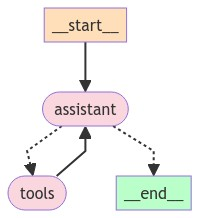

In [92]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition, 
    # "tools" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [93]:
questions = ["What is magic_function(3)",
             "What is the weather in SF?"]

In [94]:
import uuid 
_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}

events = graph.stream(
    {"messages": ("user", questions[1])}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

from_string grammar:
char ::= [^"\] | [\] char_1 
char_1 ::= ["\/bfnrt] | [u] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] 
root ::= [{] space search-query-kv [}] space 
space ::= space_6 
search-query-kv ::= ["] [s] [e] [a] [r] [c] [h] [_] [q] [u] [e] [r] [y] ["] space [:] space string 
string ::= ["] string_7 ["] space 
space_6 ::= [ ] | 
string_7 ::= char string_7 | 

llama_tokenize_internal: Added a BOS token to the prompt as specified by the model but the prompt also starts with a BOS token. So now the final prompt starts with 2 BOS tokens. Are you sure this is what you want?


================================ Human Message =================================

What is the weather in SF?


Llama.generate: prefix-match hit

llama_print_timings:        load time =   14486.48 ms
llama_print_timings:      sample time =     109.56 ms /    12 runs   (    9.13 ms per token,   109.53 tokens per second)
llama_print_timings: prompt eval time =    1999.90 ms /    57 tokens (   35.09 ms per token,    28.50 tokens per second)
llama_print_timings:        eval time =    1592.15 ms /    11 runs   (  144.74 ms per token,     6.91 tokens per second)
llama_print_timings:       total time =    3749.65 ms /    68 tokens


================================== Ai Message ==================================
Tool Calls:
  get_web_search (call__0_get_web_search_cmpl-cc27cc8d-0e39-482a-a991-33c8a33a5522)
 Call ID: call__0_get_web_search_cmpl-cc27cc8d-0e39-482a-a991-33c8a33a5522
  Args:
    search_query: weather San Francisco


Error in LangChainTracer.on_tool_end callback: TracerException("Found chain run at ID d810e414-dd2a-4243-975f-c910244b7e30, but expected {'tool'} run.")


================================= Tool Message =================================
Name: get_web_search

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718254106, 'localtime': '2024-06-12 21:48'}, 'current': {'last_updated_epoch': 1718253900, 'last_updated': '2024-06-12 21:45', 'temp_c': 15.6, 'temp_f': 60.1, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 310, 'wind_dir': 'NW', 'pressure_mb': 1012.0, 'pressure_in': 29.89, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 80, 'cloud': 25, 'feelslike_c': 15.6, 'feelslike_f': 60.1, 'windchill_c': 10.5, 'windchill_f': 50.9, 'heatindex_c': 12.6, 'heatindex_f': 54.6, 'dewpoint_c': 9.3, 'dewpoint_f': 48.8, 'vis_km': 16.0, 'vis_miles'

TypeError: can only concatenate str (not "NoneType") to str